## Passive tracers

We can follow the time evolution of material in a flow field with passive tracers.

Here we trace particles through a time-independent flow field and show how to march through time. The flow field could easily be changed at each step (exercise).

**New concepts:** Passive tracer swarms, tracer advection (equation template), variables on particle swarms


In [1]:
import underworld as uw
from underworld import function as fn
import glucifer
import numpy as np



res = 32
boxHeight = 1.0
aspect_ratio = 2.0

# A mesh to solve velocity and pressure

VPmesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q2/dPc1"), 
                                   elementRes  = (int(res * aspect_ratio), res), 
                                   minCoord    = (0., 0.), 
                                   maxCoord    = (boxHeight*aspect_ratio, boxHeight))

velocityField    = uw.mesh.MeshVariable( mesh=VPmesh,         nodeDofCount=2 )
pressureField    = uw.mesh.MeshVariable( mesh=VPmesh.subMesh, nodeDofCount=1 )

velocityField.data[:,:] = 0.0
pressureField.data[:] = 0.0


# Boundary conditions - specify:
# Vx on side walls (0) and Vx on top (1)
# Vy on top / bottom (0)

vxWalls = VPmesh.specialSets["MinI_VertexSet"] + \
          VPmesh.specialSets["MaxI_VertexSet"] + \
          VPmesh.specialSets["MaxJ_VertexSet"]

vyWalls = VPmesh.specialSets["MinJ_VertexSet"] + \
          VPmesh.specialSets["MaxJ_VertexSet"]

# We only need to specify the non-zero value of the driving terms because we zeroed everything previously

for index in VPmesh.specialSets["MaxJ_VertexSet"]:
    velocityField.data[index,0] = 1.0

    
# Now register that information

velocityBC = uw.conditions.DirichletCondition( variable = velocityField, 
                                               indexSetsPerDof = (vxWalls, vyWalls) )

    

## Passive tracer "swarm"

In parallel, the management of swarms of particles with a changing distribution
across processors can be quite complicated. 

Underworld does most things behind the scenes but only when we use the built in
functionality to handle and transport particles.

Here is how it works:



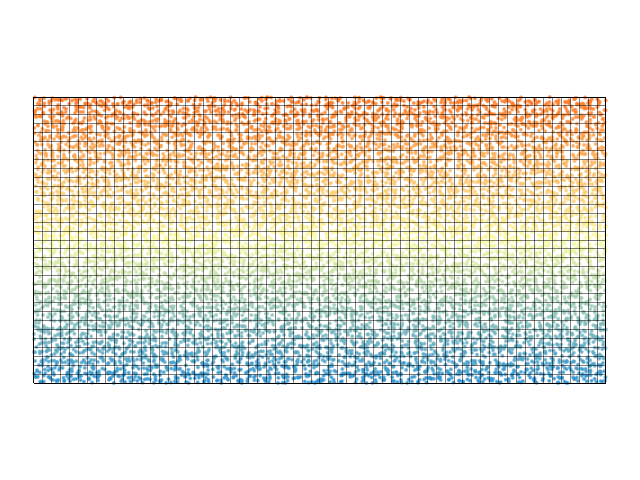

In [2]:
pt_swarm = uw.swarm.Swarm( mesh=VPmesh, particleEscape=True)
pt_swarmLayout = uw.swarm.layouts.PerCellRandomLayout( swarm=pt_swarm, particlesPerCell=5 )
pt_swarm.populate_using_layout( layout=pt_swarmLayout )


# The passive tracer can carry information as well
# We can store the initial y coordinate, for example 

pt_data = pt_swarm.add_variable( dataType="float", count=1)  # scalar value
pt_data.data[:,0] = pt_swarm.particleCoordinates.data[:,1]

fig1 = glucifer.Figure()
fig1.append( glucifer.objects.Mesh(mesh=VPmesh, opacity=0.5))
fig1.append( glucifer.objects.Points(swarm=pt_swarm, pointSize=5.0, opacity=0.95, colourBar=False, fn_colour=pt_data) )
fig1.show()


In [3]:
# The equations are templated already 

stokesPIC = uw.systems.Stokes( velocityField  = velocityField, 
                               pressureField  = pressureField,
                               conditions     = [velocityBC,],
                               fn_viscosity   = 1.0, 
                               fn_bodyforce   = (0.0,0.0) )

# And a suitable solver package is already attached to it

solver = uw.systems.Solver( stokesPIC )

In [4]:
solver.solve()


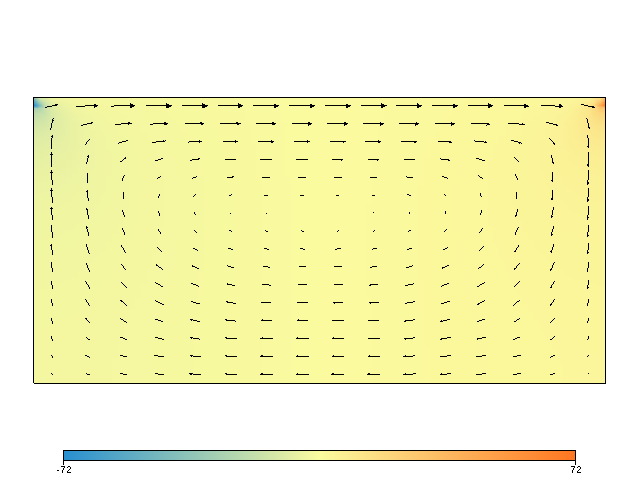

In [5]:
fig2 = glucifer.Figure()
fig2.append( glucifer.objects.VectorArrows( VPmesh, velocityField, arrowHead=0.2, scaling=0.1 ) )
fig2.append( glucifer.objects.Surface( VPmesh, pressureField ) )
fig2.show()

## Timestep the particles in a steady flow

In [6]:
advector = uw.systems.SwarmAdvector( swarm=pt_swarm, velocityField=velocityField, order=2 )
advector.get_max_dt() # similar to CFL condition, not allowing particles to move too far.


0.0078125

In [7]:
time=0.0
timeEnd = 25.0

while time<timeEnd:

    dt = advector.get_max_dt() 
    advector.integrate(dt)
      
    time += dt
    
    
# Note the lazy evaluation in fig1 ... it updates whenever 
    


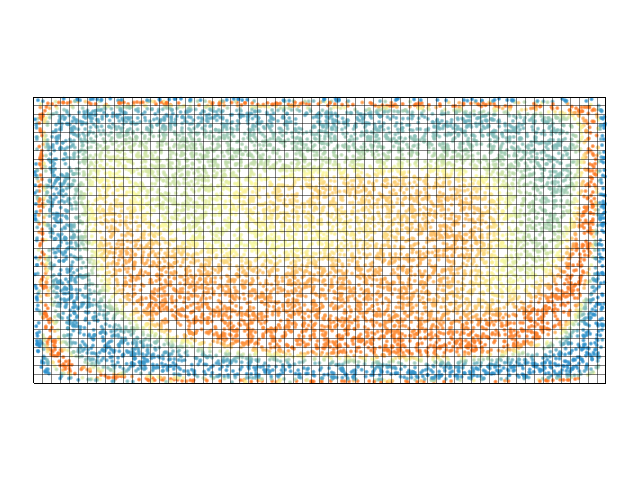

In [8]:
fig1 = glucifer.Figure()
fig1.append( glucifer.objects.Mesh(mesh=VPmesh, opacity=0.5))
fig1.append( glucifer.objects.Points(swarm=pt_swarm, pointSize=5.0, opacity=0.95, colourBar=False, fn_colour=pt_data) )
fig1.show()

## Exercises 

You could reproduce the work of Kellogg and Turcotte (1990) !  

   1. Either using their prescribed, time dependent flow equations and loading them into the velocity field or
   2. Developing a time dependent surface boundary condition to create a similar chaotic flow.


Kellogg, L. H., and D. L. Turcotte (1990), Mixing and the distribution of heterogeneities in a chaotically convecting mantle, Journal of Geophysical Research: Solid Earth (1978–2012), 95(B1), 421–432, doi:10.1029/JB095iB01p00421.

You could try making a streak plot by adding a number of new passive swarm particles launched from the same spot for the first N timesteps and then plotting all of them [Solution](042-Exercise-StreakPlot-Solution.ipynb)



